<a href="https://colab.research.google.com/github/infected4098/Oil-compete/blob/main/oil%20chek_1201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파일 임포트

In [16]:
#딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary as summary_

#하이퍼파라미터 튜닝
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms


#전처리, 점수 측정
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#컴퓨터 리소스 할당 관련 
import os
from tqdm.auto import tqdm 

#기초 툴, 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#기타
import warnings
warnings.filterwarnings("ignore")

#통계 패키지. 다중공선성 체크
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [17]:
#드라이브 소싱
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#document 위치: /Users/infected4098/Desktop/오일상태 분류

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
train = pd.read_csv("/content/gdrive/MyDrive/오일상태 분류/train.csv")

move_train = train.copy()

test = pd.read_csv("/content/gdrive/MyDrive/오일상태 분류/test.csv")


print(train.shape, test.shape)

#데이터가 14095개. feature 는 54개. 

(14095, 54) (6041, 19)


In [19]:
train_col = train.columns

#test_col = test.columns

test_col = [ 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']

# 이상치 체크

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

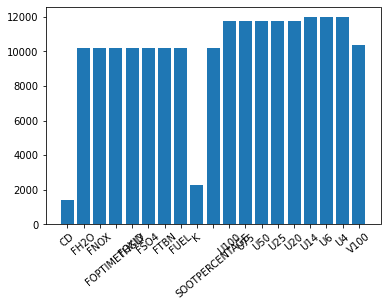

In [20]:
#무명 feature 1, 2
anon = ["ANONYMOUS_1", "ANONYMOUS_2"]
na_value = train.apply(lambda x: x.isna().sum())


real_na = na_value[na_value>0]

plt.bar(real_na.index, real_na)
plt.xticks(rotation=40)

In [21]:
#카드뮴 함유량 정보는 결측치가 1394개 있음.
#FH20. FNOX, FOPTIMETHGLY, 

#결측치들 처리 방식에 대해 고민하기
for value in list(train["CD"].unique()):
  print(value, sum(train["CD"]==value))
#0이 거의 대부분의 데이터니까 .train["CD"]는 결측값 0으로 대체

0.0 12543
nan 0
1.0 138
2.0 16
4.0 1
18.0 1
3.0 2


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
14090    0.0
14091    0.0
14092    0.0
14093    0.0
14094    0.0
Name: CD, Length: 14095, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f588bc84f70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f588bc8f670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f588bc84c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f588bc8fd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f588bc98070>],
 'means': []}

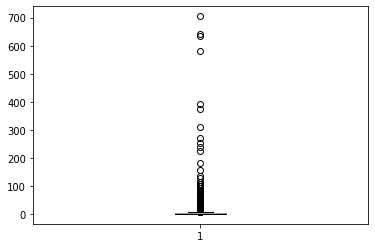

In [22]:
move_train["CD"] = move_train["CD"].fillna(0)
print(move_train["CD"])

#potassium 함유량. "K". 결측치 2292개 
K_nonna_train = train[train["K"].isna()==False]

plt.boxplot(K_nonna_train["K"])

In [23]:
K_nonna_train["K"].describe()

count    11796.000000
mean         3.611224
std         15.630404
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max        705.000000
Name: K, dtype: float64

In [24]:
K_median = K_nonna_train["K"].median()
#중위값으로 대체하자 


move_train["K"]=move_train["K"].fillna(K_median)


move_train["K"].isna().sum()

0

In [ ]:
med_na_index = real_na.index
for i in med_na_index:
  print(train[i].describe(), train[i].median(), train[i].skew())

In [26]:
move_train["FH2O"] = move_train["FH2O"].fillna(train["FH2O"].median())
move_train["FOPTIMETHGLY"] = move_train["FOPTIMETHGLY"].fillna(0) #0이 median
move_train["FNOX"] = move_train["FNOX"].fillna(7) #7이 median
move_train["FOXID"] = move_train["FOXID"].fillna(12) #12이 median
move_train["FSO4"] = move_train["FSO4"].fillna(20) #20이 median
move_train["FUEL"] = move_train["FUEL"].fillna(0) #0이 median
move_train["FTBN"] = move_train["FTBN"].fillna(train["FTBN"].mean()) #skew 하지 않으니 mean 으로 대체 

In [27]:
for leftover_index in real_na[9:].index:
  if np.abs(train[leftover_index].skew())>2.0:
    #skewed. using median
    move_train[leftover_index]=move_train[leftover_index].fillna(train[leftover_index].median())

  else:
    #not skewed. using mean
    move_train[leftover_index]=move_train[leftover_index].fillna(train[leftover_index].mean())



In [ ]:
#move_train, test 생성.

# 약한 모델 4가지 생성하는 거 노트


In [ ]:
#앙상블 4가지 
#ensemble 1 dataset: 모든 feature 다 써. scaling은 다 하고. 
#ensemble 2 dataset: AL 제거
#ensemble 3 dataset: 결측치 많은 건 다 제거 
#ensemble 4 dataset: student model에 들어가는 feature로만 학습
#ensemble _1: 깊고 얕게
#ensemble _2: 얇고 굵게 
#ensemble _3: 얇고 얕게 
#각 1, 2, 3, 4별로 ensemble _ 1, 2, 3 중 하나를 고르자 ! 

# 

In [ ]:
#ensemble 1, 2, 3, 4 는 feature 의 개수가 다 다름.

# ensemble 1 dataset

train_1 은 id, y_label 을 제외해준 데이터 파일에 
모든 component 들을 결측치 대체를 활용해 가용 상태로 바꿔준 다음, skewness에 따라 robust scaling, standard scaling 을 전부 적용해준 것이다. 

In [60]:
#train, test 까지 만든 상태. 
train_1 = move_train.copy()
test_1 = test.copy()
test_col = [ 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']

train_col = train_1.columns

le = LabelEncoder()
le.fit(train_1["COMPONENT_ARBITRARY"])
le_encoded = le.transform(train_1["COMPONENT_ARBITRARY"])
train_1["COMPONENT_ARBITRARY"] = le_encoded
X_1 = train_1.drop(["ID", "Y_LABEL"], axis=1)
y_1 = train_1["Y_LABEL"]



In [61]:
robust_col = []
standard_col = []
for col in X_1.columns:
  if X_1[col].skew()>2:
    robust_col.append(col)
  else:
    standard_col.append(col)
  
print(robust_col)
print("\n", standard_col)


['ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'PB', 'PQINDEX', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V40']

 ['COMPONENT_ARBITRARY', 'YEAR', 'CA', 'FTBN', 'P', 'S', 'V100', 'ZN']


In [62]:
for col in X_1.columns:
  if col != "COMPONENT_ARBITRARY":
    if col in robust_col:
      scaler = RobustScaler()
      X_1[col] = scaler.fit_transform(X_1[[col]])
      
      #정규화 
      scaler2 = StandardScaler()
      X_1[col] = scaler2.fit_transform(X_1[[col]])




    elif col in standard_col:
      scaler = StandardScaler()
      X_1[col] = scaler.fit_transform(X_1[[col]])

    else:
      print("#####error#####")

  
X_1.head()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
0,2,-0.393763,-0.669043,-0.051413,-0.340760,-0.150214,-0.111628,0.281646,-0.238453,-0.041491,...,-0.056904,-0.093028,-0.092629,-0.100538,-0.091369,-0.064182,-0.10655,0.0,0.899892,-0.966002
1,1,-0.426022,1.853268,3.715319,-0.022576,-0.150214,-0.123127,-0.437686,-0.238453,-0.041491,...,-0.056904,-0.216802,-0.210446,-0.287063,-0.341540,-0.778002,-0.10655,0.0,-1.317376,0.119147
2,1,-0.173409,0.339881,-0.479451,-0.340760,-0.150214,1.118753,-0.612659,0.105735,-0.041491,...,-0.123693,-0.266311,-0.223537,-0.166371,1.456213,1.739155,-0.10655,0.0,-0.740886,-0.332215
3,2,1.006399,-0.921274,-0.479451,-0.340760,-0.150214,-0.054133,-0.593217,-0.238453,-0.041491,...,-0.056904,-0.093028,-0.092629,-0.100538,-0.091369,-0.064182,-0.10655,0.0,0.482642,-1.093888
4,2,0.191634,0.339881,-0.308236,-0.340760,-0.150214,-0.134626,0.903771,-0.238453,-0.041491,...,-0.056904,-0.093028,-0.092629,-0.100538,-0.091369,-0.064182,-0.10655,0.0,0.478611,-0.866326


In [63]:
X_1.describe()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
count,14095.000000,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,...,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04
mean,1.343242,1.134247e-17,-7.444693e-15,-2.520549e-18,-7.057537e-18,-1.814795e-17,-1.159452e-17,3.024659e-17,1.209863e-17,-5.545208e-18,...,-6.049317e-18,1.814795e-17,-4.536988e-18,-2.016439e-17,-5.041098e-19,6.301372e-18,2.974248e-17,-2.117261e-16,-8.569866e-18,9.048771e-17
std,0.946841,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,...,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,0.000000,-5.090402e-01,-1.677968e+00,-6.506659e-01,-3.407601e-01,-1.502136e-01,-1.461244e-01,-6.223795e-01,-2.384531e-01,-4.149130e-02,...,-1.236926e-01,-2.663112e-01,-2.628095e-01,-3.090075e-01,-3.742563e-01,-8.605800e-01,-1.065502e-01,-1.517904e+01,-2.145827e+00,-1.107052e+00
25%,0.000000,-3.536774e-01,-9.212744e-01,-3.938433e-01,-3.407601e-01,-1.502136e-01,-1.346255e-01,-5.932173e-01,-2.384531e-01,-4.149130e-02,...,-5.690410e-02,-9.302819e-02,-9.262929e-02,-1.005384e-01,-9.136851e-02,-6.418211e-02,-1.065502e-01,0.000000e+00,-7.570116e-01,-1.037467e+00
50%,2.000000,-2.180019e-01,8.765009e-02,-2.226282e-01,-3.407601e-01,-1.502136e-01,-1.231266e-01,-5.154517e-01,-2.384531e-01,-4.149130e-02,...,-5.690410e-02,-9.302819e-02,-9.262929e-02,-1.005384e-01,-9.136851e-02,-6.418211e-02,-1.065502e-01,0.000000e+00,3.918889e-02,-1.291022e-01
75%,2.000000,1.543943e-01,8.443435e-01,3.419443e-02,4.106046e-02,-1.502136e-01,-1.001289e-01,4.468978e-01,-2.384531e-01,-4.149130e-02,...,-5.690410e-02,-9.302819e-02,-9.262929e-02,-1.005384e-01,-9.136851e-02,-6.418211e-02,-1.065502e-01,0.000000e+00,5.612545e-01,9.974209e-01
max,3.000000,6.909607e+01,2.105499e+00,3.085291e+01,1.684117e+01,1.729974e+01,5.309374e+01,1.931478e+01,7.410618e+01,5.909760e+01,...,6.259073e+01,4.060372e+01,3.811938e+01,4.100445e+01,6.678507e+01,5.276833e+01,3.565119e+01,2.958122e+01,5.505160e+01,2.902543e+00


In [64]:
print('첫번째 앙상블 x 데이터셋은 다음과 같은 형태입니다. ' , X_1.shape)
print("첫번째 앙상블 y 데이터셋은 다음과 같은 형태입니다. ", y_1.shape)

첫번째 앙상블 x 데이터셋은 다음과 같은 형태입니다.  (14095, 52)
첫번째 앙상블 y 데이터셋은 다음과 같은 형태입니다.  (14095,)


# ensemble 2 dataset

ensemble 2 는 알루미늄이 없습니다.

In [65]:
#ensemble 2 는 알루미늄이 제거된 것. 
X_2 = X_1.copy()
y_2 = y_1.copy()
X_2 = X_1.drop(["AL"], axis = 1)

print('두번째 앙상블 x 데이터셋은 다음과 같은 형태입니다. ' , X_2.shape)
print("두번째 앙상블 y 데이터셋은 다음과 같은 형태입니다. ", y_2.shape)

두번째 앙상블 x 데이터셋은 다음과 같은 형태입니다.  (14095, 51)
두번째 앙상블 y 데이터셋은 다음과 같은 형태입니다.  (14095,)


# ensemble 3 dataset

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

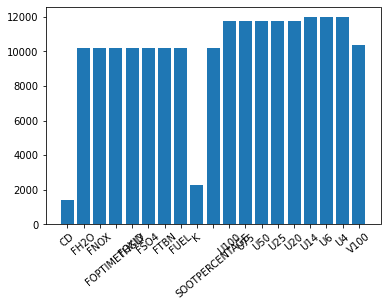

In [66]:
X_for_3 = train.copy()
na_value = X_for_3.apply(lambda x: x.isna().sum())


real_na = na_value[na_value>0]

plt.bar(real_na.index, real_na)
plt.xticks(rotation=40)

In [75]:
X_for_3 = train.copy()
na_value = X_for_3.apply(lambda x: x.isna().sum())
real_na = na_value[na_value>0]
almost_na = list(real_na[real_na>8000].index)
X_for_3 = X_for_3.drop(almost_na, axis = 1)
print(X_for_3.shape)

(14095, 37)


In [77]:
#범주형 데이터 처리
le = LabelEncoder()
le.fit(X_for_3["COMPONENT_ARBITRARY"])
le_encoded = le.transform(X_for_3["COMPONENT_ARBITRARY"])
X_for_3["COMPONENT_ARBITRARY"] = le_encoded


In [ ]:
X_for_3["CD"] = X_for_3["CD"].fillna(0)
X_for_3["K"] = X_for_3["K"].fillna(X_for_3["K"].median())

X_for_3.apply(lambda x : x.isna().sum())

In [79]:
#scaling
X_3 = X_for_3.drop(["Y_LABEL", "ID"], axis = 1)
y_3 = X_for_3["Y_LABEL"]
robust_col = []
standard_col = []
for col in X_3.columns:
  if X_3[col].skew()>2:
    robust_col.append(col)
  else:
    standard_col.append(col)
  
print(robust_col)
print("\n", standard_col)


['ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'PB', 'PQINDEX', 'SB', 'SI', 'SN', 'TI', 'V', 'V40']

 ['COMPONENT_ARBITRARY', 'YEAR', 'CA', 'P', 'S', 'ZN']


In [81]:
for col in X_3.columns:
  if col != "COMPONENT_ARBITRARY":
    if col in robust_col:
      scaler = RobustScaler()
      X_3[col] = scaler.fit_transform(X_3[[col]])
      
      #정규화 
      scaler2 = StandardScaler()
      X_3[col] = scaler2.fit_transform(X_3[[col]])




    elif col in standard_col:
      scaler = StandardScaler()
      X_3[col] = scaler.fit_transform(X_3[[col]])

    else:
      print("#####error#####")

X_3.head(5)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
0,2,-0.393763,-0.669043,-0.051413,-0.340760,-0.150214,-0.111628,0.281646,-0.238453,-0.041491,...,-0.160812,5.293270,1.001652,-0.174727,2.006643,0.302478,0.622282,-0.10655,0.899892,-0.966002
1,1,-0.426022,1.853268,3.715319,-0.022576,-0.150214,-0.123127,-0.437686,-0.238453,-0.041491,...,0.033010,-0.259244,-1.170187,-0.174727,-0.179489,-0.252439,-0.102635,-0.10655,-1.317376,0.119147
2,1,-0.173409,0.339881,-0.479451,-0.340760,-0.150214,1.118753,-0.612659,0.105735,-0.041491,...,-0.160812,-0.260552,-1.146917,-0.174727,-0.179489,0.025019,-0.102635,-0.10655,-0.740886,-0.332215
3,2,1.006399,-0.921274,-0.479451,-0.340760,-0.150214,-0.054133,-0.593217,-0.238453,-0.041491,...,-0.063901,-0.242884,1.044975,0.557916,-0.174370,0.025019,-0.102635,-0.10655,0.482642,-1.093888
4,2,0.191634,0.339881,-0.308236,-0.340760,-0.150214,-0.134626,0.903771,-0.238453,-0.041491,...,-0.160812,-0.129674,0.690669,-0.174727,-0.169250,-0.252439,-0.102635,-0.10655,0.478611,-0.866326


In [82]:
X_3.describe()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN
count,14095.000000,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,...,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04,1.409500e+04
mean,1.343242,-6.049317e-18,2.621371e-17,9.830141e-18,2.520549e-18,-1.814795e-17,-5.041098e-18,-3.881645e-17,4.032878e-17,-1.260274e-17,...,-2.570960e-17,1.109042e-17,4.133700e-17,2.621371e-17,-3.024659e-18,1.537535e-17,-4.536988e-18,3.377536e-17,-4.536988e-18,3.932056e-17
std,0.946841,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,...,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,0.000000,-5.090402e-01,-1.677968e+00,-6.506659e-01,-3.407601e-01,-1.502136e-01,-1.461244e-01,-6.223795e-01,-2.384531e-01,-4.149130e-02,...,-1.608122e-01,-2.716770e-01,-1.248576e+00,-1.747274e-01,-1.794894e-01,-2.524386e-01,-1.026354e-01,-1.065502e-01,-2.145827e+00,-1.107052e+00
25%,0.000000,-3.536774e-01,-9.212744e-01,-3.938433e-01,-3.407601e-01,-1.502136e-01,-1.346255e-01,-5.932173e-01,-2.384531e-01,-4.149130e-02,...,-1.608122e-01,-2.638243e-01,-8.137899e-01,-1.747274e-01,-1.641302e-01,-2.524386e-01,-1.026354e-01,-1.065502e-01,-7.570116e-01,-1.037467e+00
50%,2.000000,-2.180019e-01,8.765009e-02,-2.226282e-01,-3.407601e-01,-1.502136e-01,-1.231266e-01,-5.154517e-01,-2.384531e-01,-4.149130e-02,...,-1.608122e-01,-2.526996e-01,-4.284396e-01,-1.747274e-01,-1.487709e-01,-2.524386e-01,-1.026354e-01,-1.065502e-01,3.918889e-02,-1.291022e-01
75%,2.000000,1.543943e-01,8.443435e-01,3.419443e-02,4.106046e-02,-1.502136e-01,-1.001289e-01,4.468978e-01,-2.384531e-01,-4.149130e-02,...,3.300950e-02,-1.532321e-01,8.279303e-01,-1.747274e-01,-1.180524e-01,2.501946e-02,-1.026354e-01,-1.065502e-01,5.612545e-01,9.974209e-01
max,3.000000,6.909607e+01,2.105499e+00,3.085291e+01,1.684117e+01,1.729974e+01,5.309374e+01,1.931478e+01,7.410618e+01,5.909760e+01,...,7.116556e+01,3.687225e+01,5.590254e+00,3.755643e+01,2.776922e+01,7.993295e+01,5.832574e+01,3.565119e+01,5.505160e+01,2.902543e+00


In [83]:
print('세번째 앙상블 x 데이터셋은 다음과 같은 형태입니다. ' , X_3.shape)
print("세번째 앙상블 y 데이터셋은 다음과 같은 형태입니다. ", y_3.shape)

세번째 앙상블 x 데이터셋은 다음과 같은 형태입니다.  (14095, 35)
세번째 앙상블 y 데이터셋은 다음과 같은 형태입니다.  (14095,)


# ensemble 4 dataset

In [ ]:
X_for_4 = train.copy()


# parameter, ensemble 모델들 정의


In [ ]:
#hyperparameter tuning 을 해야하기 때문

CFG_list = {
    'EPOCHS': [10, 20],
    'LEARNING_RATE':[1e-1, 1e-2, 1e-3],
    'BATCH_SIZE':[32, 64, 128],
    'SEED':[41]
}

In [ ]:
class Teacher_1(nn.Module): #6층짜리 
    def __init__(self, i_feat):
        super(Teacher_1, self).__init__()
        self.in_features = i_feat
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
class Teacher_2(nn.Module): #4층짜리 
    def __init__(self, i_feat):
        super(Teacher_2, self).__init__()
        self.in_features = i_feat
        self.classifier = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
class Teacher_3(nn.Module): #4층짜리. light.
    def __init__(self, i_feat):
        super(Teacher_3, self).__init__()
        self.in_features = i_feat
        self.classifier = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

# Parellizable 함수

데이터셋 **구축**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_col].iloc[index]) #보수부분. student는 19개 정도의 column만 갖고 있음
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
                
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y